In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sklearn

Text(0.5, 1.0, 'Cropped Image')

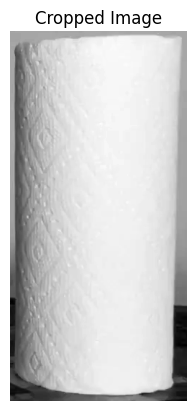

In [7]:
### Question 1

# Load the reference image and cropped ROI
reference_image = cv2.imread('./image_dataset/frame_0.png')
cropped_roi = reference_image[277:793, 1529:1775] 
cropped_roi_gray = cv2.cvtColor(cropped_roi, cv2.COLOR_BGR2GRAY)

plt.imshow(cropped_roi_gray, cmap = 'gray')
plt.axis(False)
plt.title('Cropped Image')


In [8]:
def overlay_rectangle(image, top_left, bottom_right, color=(0, 0, 255), thickness=2):
    return cv2.rectangle(image, top_left, bottom_right, color, thickness)


In [9]:

# Path to the directory containing the dataset of images
dataset_dir = './image_dataset/'

# Get a list of all image files in the dataset directory
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.png')]

# Randomly select 10 images from the dataset
random.seed(42)
selected_images = random.sample(image_files, 10)


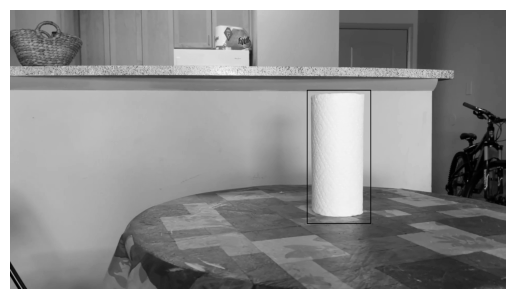

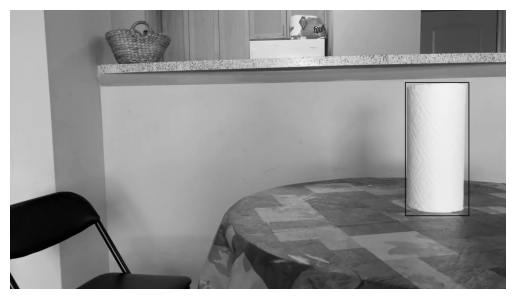

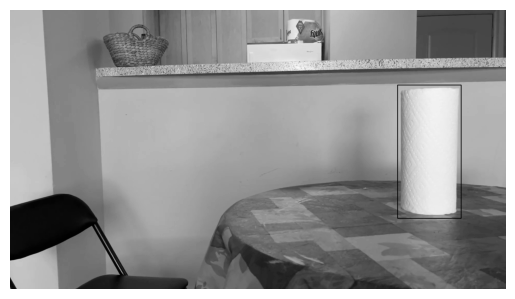

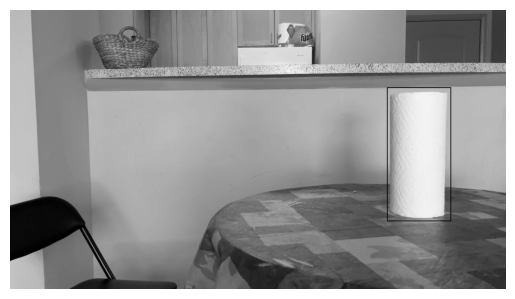

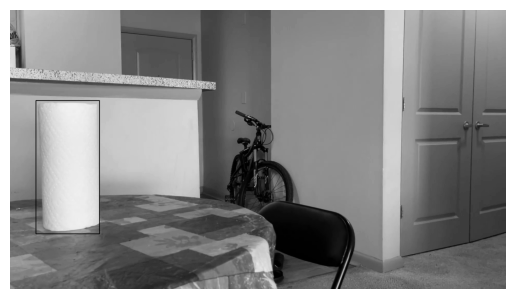

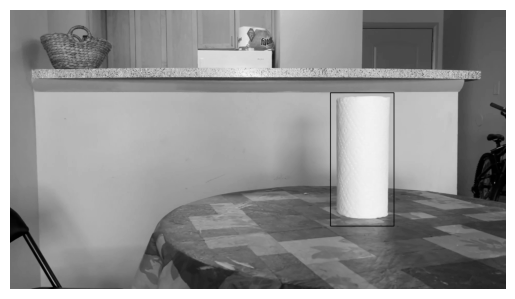

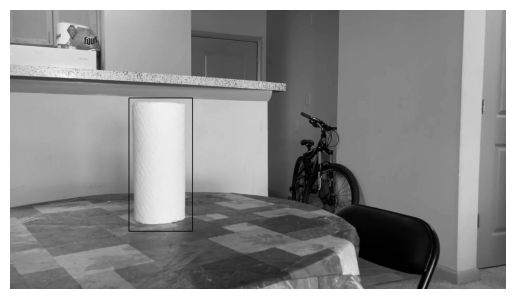

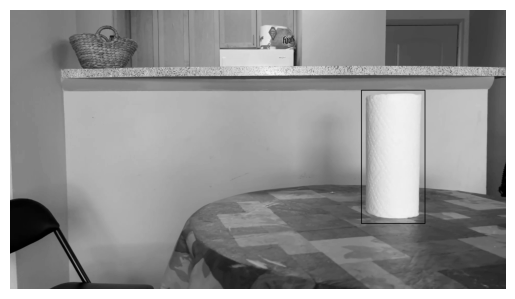

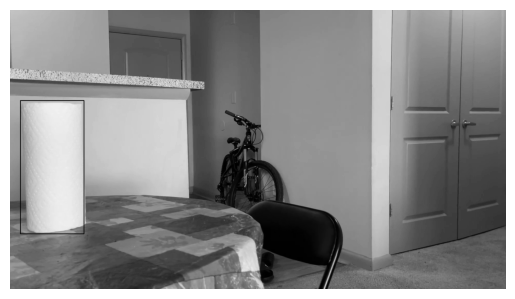

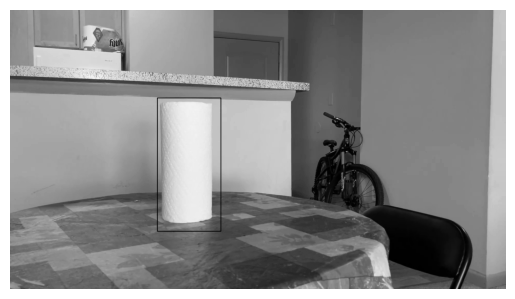

In [10]:

# Process each selected image
for image_file in selected_images:
    # Load the current image
    current_image = cv2.imread(os.path.join(dataset_dir, image_file))
    current_image_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
    
    # Initialize lists to store SSD differences and coordinates for the current image
    ssds = []
    coords = []
    
    # Iterate over the current image with a sliding window of the same size as the cropped ROI
    for i in range(0, current_image_gray.shape[0] - cropped_roi_gray.shape[0], 10):
        for j in range(0, current_image_gray.shape[1] - cropped_roi_gray.shape[1], 10):
            # Extract ROI from the current image
            roi = current_image_gray[i:i+cropped_roi_gray.shape[0], j:j+cropped_roi_gray.shape[1]]
           
            # Compute SSD between the cropped ROI and the current ROI
            ssd = np.sum((roi - cropped_roi_gray) ** 2)
            
            # Append SSD difference and coordinates to the lists
            ssds.append(ssd)
            coords.append((i, j))
    
    # Check if the minimum SSD is below a threshold (indicating a match)
    min_ssd_index = np.argmin(ssds)
    min_ssd = ssds[min_ssd_index]
    min_coord = coords[min_ssd_index]

    # Calculate bottom-right corner of the rectangle based on the size of the detected object
    bottom_right = (min_coord[0] + cropped_roi.shape[0], min_coord[1] + cropped_roi.shape[1])
        
    # Overlay rectangle on the current image
    overlay_image = overlay_rectangle(current_image_gray.copy(), min_coord[::-1], bottom_right[::-1])

    # Display the image with the overlay
    plt.imshow(overlay_image, cmap='gray')
    plt.axis('off')
    plt.show()




In [ ]:
### Question 4

# Load images
image1 = cv2.imread('bottle_image1.jpg')
image2 = cv2.imread('bottle_image2.jpg')

# Convert images to grayscale
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Detect SIFT keypoints and descriptors in both images
sift = cv2.SIFT_create()
image1_keypoints, image1_descriptors = sift.detectAndCompute(image1_gray, None)
image2_keypoints, image2_descriptors = sift.detectAndCompute(image2_gray, None)

# Match keypoints between the two images
bf = cv2.BFMatcher()
matches = bf.match(image1_descriptors, image2_descriptors)
matches = sorted(matches, key=lambda x: x.distance)

# Compute fundamental matrix
image1_points = np.float32([image1_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
image2_points = np.float32([image2_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
fundamental_matrix, _ = cv2.findFundamentalMat(image1_points, image2_points, cv2.FM_RANSAC)

# Rectify images
_, H1, H2 = cv2.stereoRectifyUncalibrated(image1_points, image2_points, fundamental_matrix, image1_gray.shape[:2])
rectified_image1 = cv2.warpPerspective(image1_gray, H1, image1_gray.shape[::-1])
rectified_image2 = cv2.warpPerspective(image2_gray, H2, image2_gray.shape[::-1])

# Compute disparity
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(rectified_image1, rectified_image2)

# Convert disparity to depth map
baseline = 0.61  # Baseline distance in meters
focal_length = 1600  # Focal length in pixels
depth_map = baseline * focal_length / (disparity + 0.0001)

# Measure distance from camera to marker in depth map
marker_depth = depth_map[2594, 2323]  # Example coordinates of the marker
estimated_distance = marker_depth
print("Estimated distance:", estimated_distance)


In [11]:

### Question 4

#i. treating every previous frame as a reference frame

# Load the video file
video_file = 'video.mp4'
cap = cv2.VideoCapture(video_file)

# Initialize previous frame
ret, prev_frame = cap.read()
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Parameters for the optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Define the color for the optical flow vectors
color = (0, 255, 0)

# Iterate through each frame
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the current frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Draw optical flow vectors on the frame
    for y in range(0, frame.shape[0], 10):
        for x in range(0, frame.shape[1], 10):
            dx, dy = flow[y, x]
            cv2.arrowedLine(frame, (x, y), (int(x+dx*10), int(y+dy*10)), color, 1)
    
    # Show the frame with optical flow vectors
    cv2.imshow('Optical Flow Vectors', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
    
    # Update the previous frame
    prev_frame_gray = frame_gray.copy()

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [12]:
#ii. treating every 11th frame as a reference frame

# Load the video file
video_file = 'video.mp4'
cap = cv2.VideoCapture(video_file)

# Initialize previous frame
ret, prev_frame = cap.read()
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Parameters for the optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Define the color for the optical flow vectors
color = (0, 255, 0)

frame_count = 1

# Iterate through each frame
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1

    # Skip frames until we reach the 11th frame
    if frame_count % 11 != 0:
        continue

    # Convert the current frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Draw optical flow vectors on the frame
    for y in range(0, frame.shape[0], 10):
        for x in range(0, frame.shape[1], 10):
            dx, dy = flow[y, x]
            cv2.arrowedLine(frame, (x, y), (int(x+dx), int(y+dy)), color, 2)  # Increase arrow length and thickness
    
    # Show the frame with optical flow vectors
    cv2.imshow('Optical Flow Vectors', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
    
    # Update the previous frame
    prev_frame_gray = frame_gray.copy()

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [13]:
#iii. treating every 31st frame as a reference frame

# Load the video file
video_file = 'video.mp4'
cap = cv2.VideoCapture(video_file)

# Initialize previous frame
ret, prev_frame = cap.read()
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Parameters for the optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Define the color for the optical flow vectors
color = (0, 255, 0)

frame_count = 1

# Iterate through each frame
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1

    # Skip frames until we reach the 11th frame
    if frame_count % 31 != 0:
        continue

    # Convert the current frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Draw optical flow vectors on the frame
    for y in range(0, frame.shape[0], 10):
        for x in range(0, frame.shape[1], 10):
            dx, dy = flow[y, x]
            cv2.arrowedLine(frame, (x, y), (int(x+dx), int(y+dy)), color, 2)  # Increase arrow length and thickness
    
    # Show the frame with optical flow vectors
    cv2.imshow('Optical Flow Vectors', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
    
    # Update the previous frame
    prev_frame_gray = frame_gray.copy()

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [14]:
### Question 5

# Create SIFT detector
sift = cv2.SIFT_create()

(-0.5, 245.5, 515.5, -0.5)

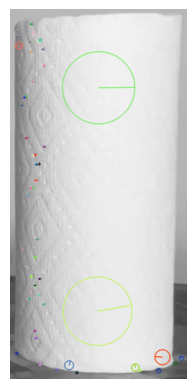

In [16]:
cropped_roi_gray
keyFeats = sift.detect(cropped_roi, None)
boxImage_with_keypoints = cv2.drawKeypoints(cropped_roi_gray, keyFeats, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the image with keypoints
plt.imshow(cv2.cvtColor(boxImage_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis(False)

In [17]:


# Load images
for image in selected_images:

    sceneImage = cv2.imread(os.path.join(dataset_dir,image))

    keypoints = sift.detect(sceneImage, None)

    # Draw the keypoints on the image
    boxImage_with_keypoints = cv2.drawKeypoints(sceneImage, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # # Plot the image with keypoints
    # plt.imshow(cv2.cvtColor(boxImage_with_keypoints, cv2.COLOR_BGR2RGB)) # Uncomment this to display the plots for each selected image.
    # plt.axis(False)


In [18]:


# Detect keypoints and compute descriptors
cropped_roipoints, cropped_roiDescriptors = sift.detectAndCompute(cropped_roi_gray, None)
for image in selected_images:

    sceneImage = cv2.imread(os.path.join(dataset_dir,image))
    sceneImage_gray = cv2.cvtColor(sceneImage, cv2.COLOR_BGR2GRAY)

    sceneKeypoints, sceneDescriptors = sift.detectAndCompute(sceneImage_gray, None)

    # Match descriptors using FLANN matcher
    flann = cv2.FlannBasedMatcher()
    matches = flann.knnMatch(cropped_roiDescriptors, sceneDescriptors, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw matches
    matched_img = cv2.drawMatches(cropped_roi_gray, cropped_roipoints, sceneImage_gray, sceneKeypoints, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # # Display the image
    # plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)) # Uncomment this to display the plots for each selected image.
    # plt.axis(False)
    # plt.show()


In [19]:
# Initialize lists to store keypoints
cropped_roipoints_matched = []
sceneKeypoints_matched = []

# Extract matching keypoints from good_matches
for match in good_matches:
    # Get the index of the descriptor in the query image (cropped_roiDescriptors)
    query_idx = match.queryIdx
    # Get the index of the descriptor in the train image (sceneDescriptors)
    train_idx = match.trainIdx
    # Retrieve the corresponding keypoints
    cropped_roipoints_matched.append(cropped_roipoints[query_idx].pt)
    sceneKeypoints_matched.append(sceneKeypoints[train_idx].pt)

# Convert the lists to numpy arrays
cropped_roipoints_matched_np = np.array(cropped_roipoints_matched)
sceneKeypoints_matched_np = np.array(sceneKeypoints_matched)

# Estimate the affine transformation
tform = cv2.estimateAffine2D(cropped_roipoints_matched_np, sceneKeypoints_matched_np)[0]


(-0.5, 1919.5, 1079.5, -0.5)

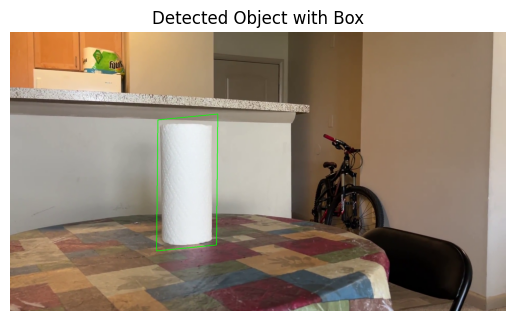

In [24]:
# Get the corners of the cropped ROI
h, w = cropped_roi_gray.shape
cropped_roi_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]])

# Project the corners of the cropped ROI onto the scene image using the estimated affine transformation
transformed_corners = cv2.transform(np.array([cropped_roi_corners]), tform)[0]

# Draw a rectangle around the detected object
sceneImage_with_box = cv2.polylines(sceneImage, [np.int32(transformed_corners)], isClosed=True, color=(0, 255, 0), thickness=2)

# Display the image with the detected object
plt.imshow(cv2.cvtColor(sceneImage_with_box, cv2.COLOR_BGR2RGB))
plt.title('Detected Object with Box')
plt.axis(False)


In [2]:
### Question 6

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [ ]:


def load_images(folder_path):
    images = []
    labels = []
    categories = ['spoon', 'fork', 'mixer', 'chopstick', 'rice-spoon']
    
    for category in categories:
        category_folder = os.path.join(folder_path, category)
        for filename in os.listdir(category_folder):
            img_path = os.path.join(category_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(category)
    
    return images, labels

def extract_keypoints_and_descriptors(images):
    sift = cv2.SIFT_create()
    keypoints_list = []
    descriptors_list = []
    
    for img in images:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
    
    return keypoints_list, descriptors_list

def create_vocabulary(descriptors_list, vocabulary_size):
    all_descriptors = np.concatenate(descriptors_list)
    kmeans = KMeans(n_clusters=vocabulary_size)
    kmeans.fit(all_descriptors)
    return kmeans

def extract_image_features(image, vocabulary):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None:
        return np.zeros(vocabulary.cluster_centers_.shape[0])
    else:
        labels = vocabulary.predict(descriptors)
        features = np.bincount(labels, minlength=vocabulary.cluster_centers_.shape[0])
        return features

folder_path = 'question6_photos'
vocabulary_size = 50

# Load images and corresponding labels
images, labels = load_images(folder_path)

# Extract keypoints and descriptors for each image
keypoints_list, descriptors_list = extract_keypoints_and_descriptors(images)

# Build vocabulary using KMeans clustering
vocabulary = create_vocabulary(descriptors_list, vocabulary_size)

# Extract features for each image based on the vocabulary
features = []
for img in images:
    features.append(extract_image_features(img, vocabulary))
features = np.array(features)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(features_scaled, labels)

# Evaluate performance
predicted_labels = svm_classifier.predict(features_scaled)
accuracy = np.mean(predicted_labels == labels)
print("Accuracy on training set:", accuracy)

# Visualize recognition results
for i, img in enumerate(images):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    actual_label = labels[i]
    predicted_label = predicted_labels[i]
    text = f"Actual: {actual_label}, Predicted: {predicted_label}"
    cv2.imshow(text, img_bgr)
    cv2.waitKey(0)
